In [1]:
%matplotlib inline
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [2]:
gpu = torch.cuda.is_available()
gpu

True

In [3]:
vgg = models.vgg19(pretrained=True).features
for para in vgg.parameters():
    para.requires_grad_(False)
    
if gpu:
    vgg.to('cuda')
    device = torch.device('cuda')

In [4]:
def load_image(img_path, max_size=400, shape=None):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
        
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [5]:
#content_path = input()
#style_path = input()
# load in content and style image
content = load_image('content/1.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('style/1.jpg', shape=content.shape[-2:]).to(device)

In [6]:

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
  #  image = tensor.clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

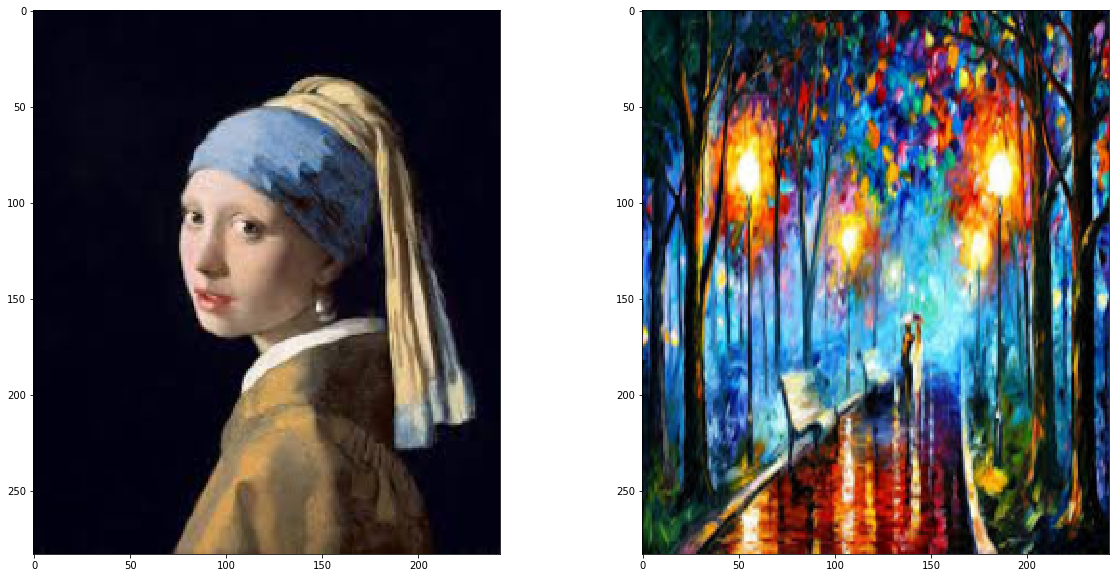

In [7]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [8]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [9]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram 

In [10]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)


style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [11]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.5,
                 'conv4_1': 0.25,
                 'conv5_1': 0.25}

content_weight = 1  
style_weight = 1e6  

Total loss:  10163121.0


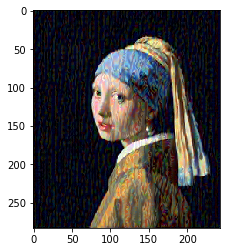

Total loss:  4612236.5


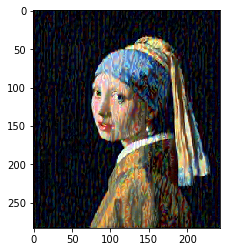

Total loss:  3063496.0


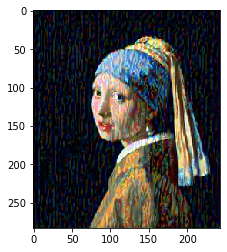

Total loss:  2304125.75


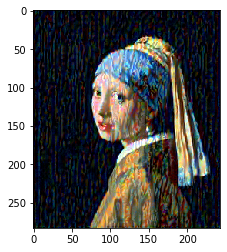

Total loss:  1841732.75


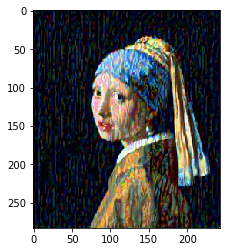

Total loss:  1524574.625


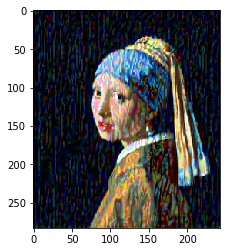

Total loss:  1291140.875


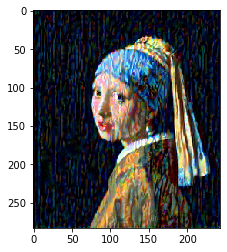

Total loss:  1111091.875


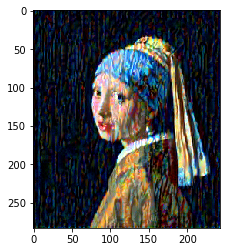

Total loss:  968621.375


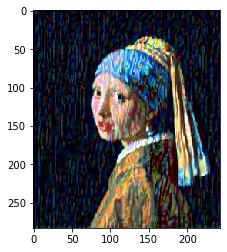

Total loss:  853613.375


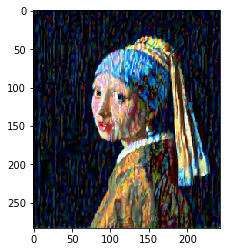

Total loss:  759204.5625


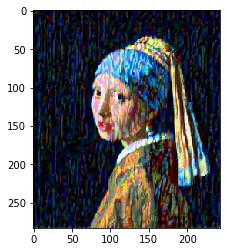

Total loss:  681218.375


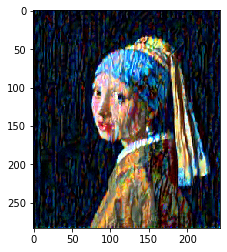

Total loss:  616175.1875


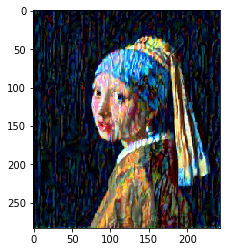

Total loss:  561403.4375


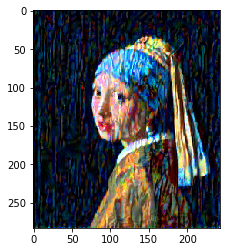

Total loss:  514958.78125


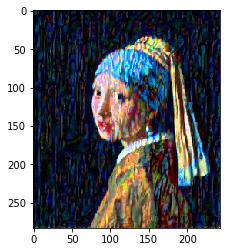

Total loss:  475115.21875


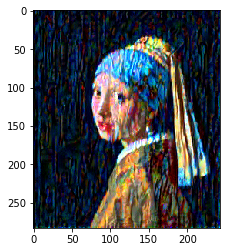

Total loss:  440577.8125


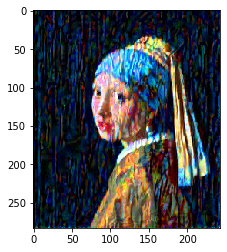

Total loss:  410214.96875


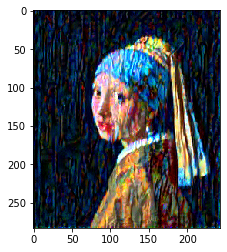

Total loss:  383236.28125


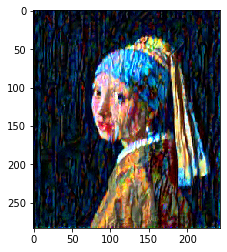

Total loss:  359072.46875


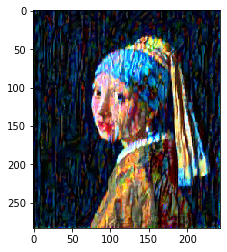

In [12]:
show_every = 100

optimizer = optim.Adam([target], lr=0.003)
steps = 2000  

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0

    for layer in style_weights:

        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape

        style_gram = style_grams[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        style_loss += layer_style_loss / (d * h * w)
        

    total_loss = content_weight * content_loss + style_weight * style_loss
    
 
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

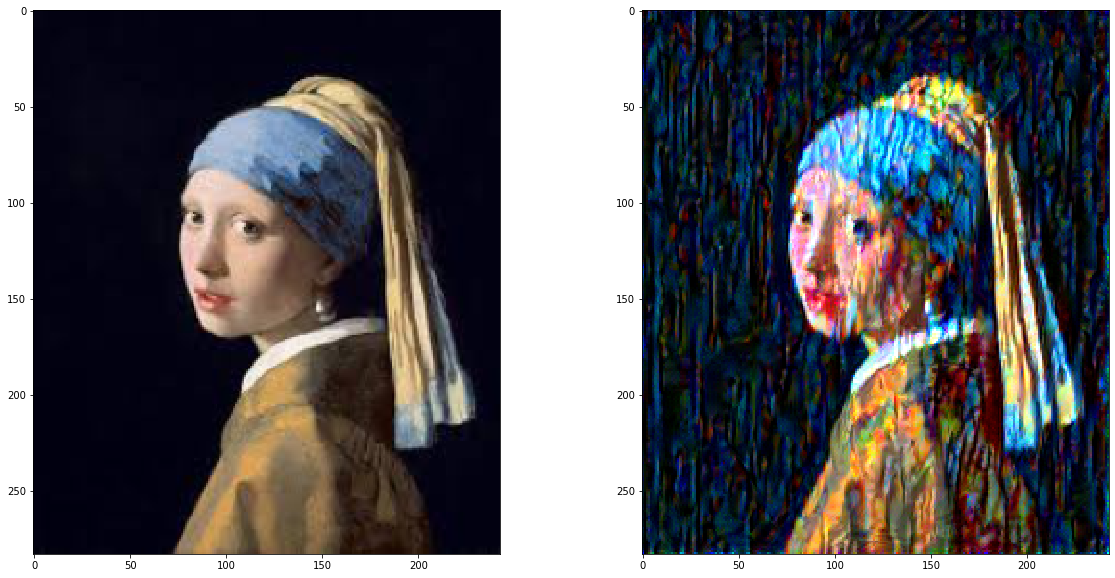

In [13]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))